# Разработка решения для персонализации предложений постоянным клиентам Интернет-магазина «В один клик»
В целях удержания активности постоянных клиентов интернет-магазин «В один клик» (Заказчик) принял решение персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. 
Для этого нужно: 
1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Описание данных**\
Даны четыре талицы.\
1) Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:\
*market_file.csv*
\
'id' — номер покупателя в корпоративной базе данных.\
'Покупательская активность' — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».\
'Тип сервиса' — уровень сервиса, например «премиум» и «стандарт».\
'Разрешить сообщать' — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.\
'Маркет_актив_6_мес' — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.\
'Маркет_актив_тек_мес' — количество маркетинговых коммуникаций в текущем месяце.\
'Длительность' — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.\
'Акционные_покупки' — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.\
'Популярная_категория' — самая популярная категория товаров у покупателя за последние 6 месяцев.\
'Средний_просмотр_категорий_за_визит' — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.\
'Неоплаченные_продукты_штук_квартал' — общее число неоплаченных товаров в корзине за последние 3 месяца.\
'Ошибка_сервиса' — число сбоев, которые коснулись покупателя во время посещения сайта.\
'Страниц_за_визит' — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.\


2) Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:\
*market_money.csv*\
'id' — номер покупателя в корпоративной базе данных.\
'Период' — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.\
'Выручка' — сумма выручки за период.\


3) Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода:\
*market_time.csv*\
'id' — номер покупателя в корпоративной базе данных.\
'Период' — название периода, во время которого зафиксировано общее время.\
'минут' — значение времени, проведённого на сайте, в минутах.\


4) Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:\
*money.csv*\
'id' — номер покупателя в корпоративной базе данных.
'Прибыль' — значение прибыли.

## Загрузка данных

In [1]:
#Импортирую нужные библиотеки и классы
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix,
    mean_absolute_error, 
    mean_squared_error,
    f1_score,
    roc_auc_score
)
try:
    import phik
except:
    !pip install -q phik
    import phik
from phik.report import plot_correlation_matrix

#класс pipeline
from sklearn.pipeline import Pipeline

#классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

#класс для работы с пропусками
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest, f_classif

!pip install shap -q 
import shap

from warnings import simplefilter
#ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Загружаю каждую таблицу и вывожу информацию о датафреймах.

In [2]:
market = pd.read_csv('market_file.csv')
market.info()
market.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [3]:
market_money = pd.read_csv('market_money.csv')
market_money.info()
market_money.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [4]:
market_time = pd.read_csv('market_time.csv')
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [5]:
money = pd.read_csv('money.csv', sep=';', decimal = ',')
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Предварительно можно отметить, что данные есть по 1300 клиентам. В таблицах *market_money* и *market_time* строк в три и в два раза больше, т.к. там одному клиенту соответствует несколько строк с разными периодами.\
Нужно будет проверить категориальные столбцы на предмет опечаток. Например, в Типе сервиса странно выглядит значение "стандартт".\
В таблице *market_time* хочется переименовать наименование столбца "минуты" в, например, "Минут_на_сайте", т.к. это будет более удобно для восприятия и, кроме того, все остальные столбцы начинаются с заглавной буквы.

## Предобработка данных

### Предобработка первой таблицы *market*

In [6]:
#вывожу на экран уникальные зачения и их количество для столбцов, содержащих категоральные признаки
for i in market.select_dtypes(exclude='number').columns.tolist():
    print(market[i].value_counts())
    print()

Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64

Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64



In [7]:
#корректирую опечатку в типе сервиса
market['Тип сервиса'] = market['Тип сервиса'].str.replace('стандартт', 'стандарт')

In [8]:
#проверяю на наличие явных дубликатов
market.duplicated().sum()

0

### Предобработка второй таблицы *market_money*

In [9]:
market_money['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [10]:
#корректирую опечатку
market_money['Период'] = market_money['Период'].str.replace('препредыдущий_месяц', 'предпредыдущий_месяц')

In [11]:
#проверяю на наличие явных дубликатов
market_money.duplicated().sum()

0

In [12]:
market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

### Предобработка третьей таблицы *market_time*

In [13]:
market_time['Период'].value_counts()

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [14]:
#корректирую опечатку
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [15]:
#проверяю на наличие явных дубликатов
market_time.duplicated().sum()

0

### Предобработка четвертой таблицы *money*

In [16]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

In [17]:
#money['Прибыль'] = money['Прибыль']*1000

## Исследовательский анализ данных

### Исследовательский анализ данных первой таблицы *market*

In [18]:
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


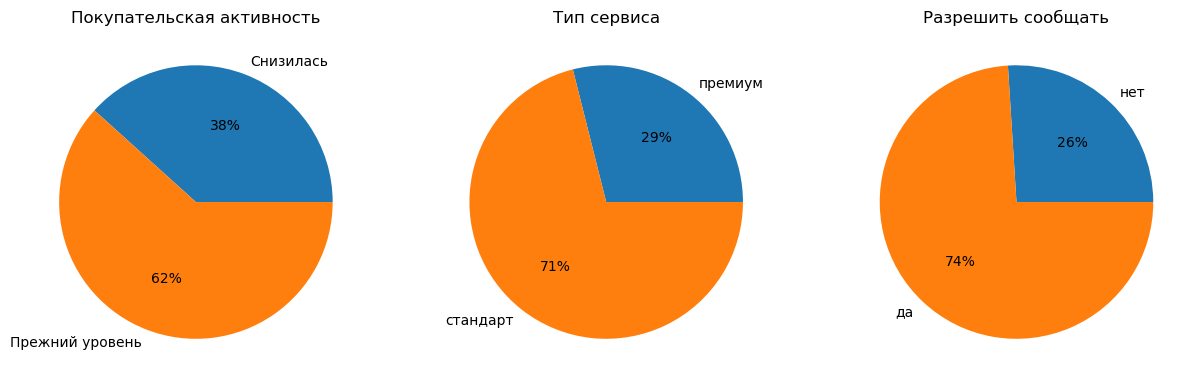

In [19]:
market_col=['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать']
n=0
plt.figure(figsize=(15, 10))
for col in market_col:
    m=n+1
    plt.subplot(1, 3, m)
    n=m
    market[col].value_counts().sort_values().plot(kind='pie', autopct='%1.0f%%', title=col, ylabel="");
    print()

Покупательская способность снизилась у 38% покупателей, у остальных осталась на прежнем уровне. Такой дисбаланс нужно будет учитывать на последующих этапах. Интересно, почему нет категории "повысилась". \
Почти у 30% покупателей тип сервиса "премиум", а у 70% - "стандарт".\
Три четверти покупателей разрешают сообщать им о дополнительных предложениях о товаре.

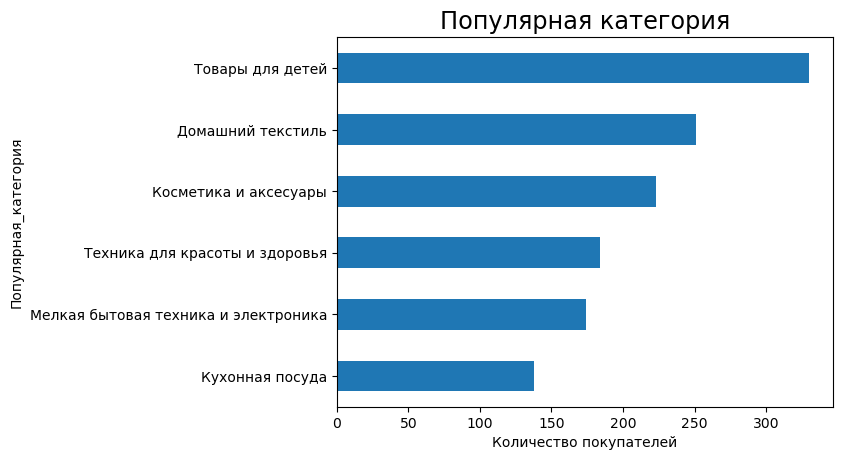

In [20]:
market['Популярная_категория'].value_counts().sort_values().plot.barh()
plt.title('Популярная категория', size="xx-large")
plt.xlabel("Количество покупателей");

Самая популярная катеория - "Товары для детей". На втором месте "Домашний текстиль".\ 
Затем по порядку "Косметика и аксесуары", "Техника для красоты и здоровья", "Мелкая бытовая техника и элетроника", "Кухонная посуда".

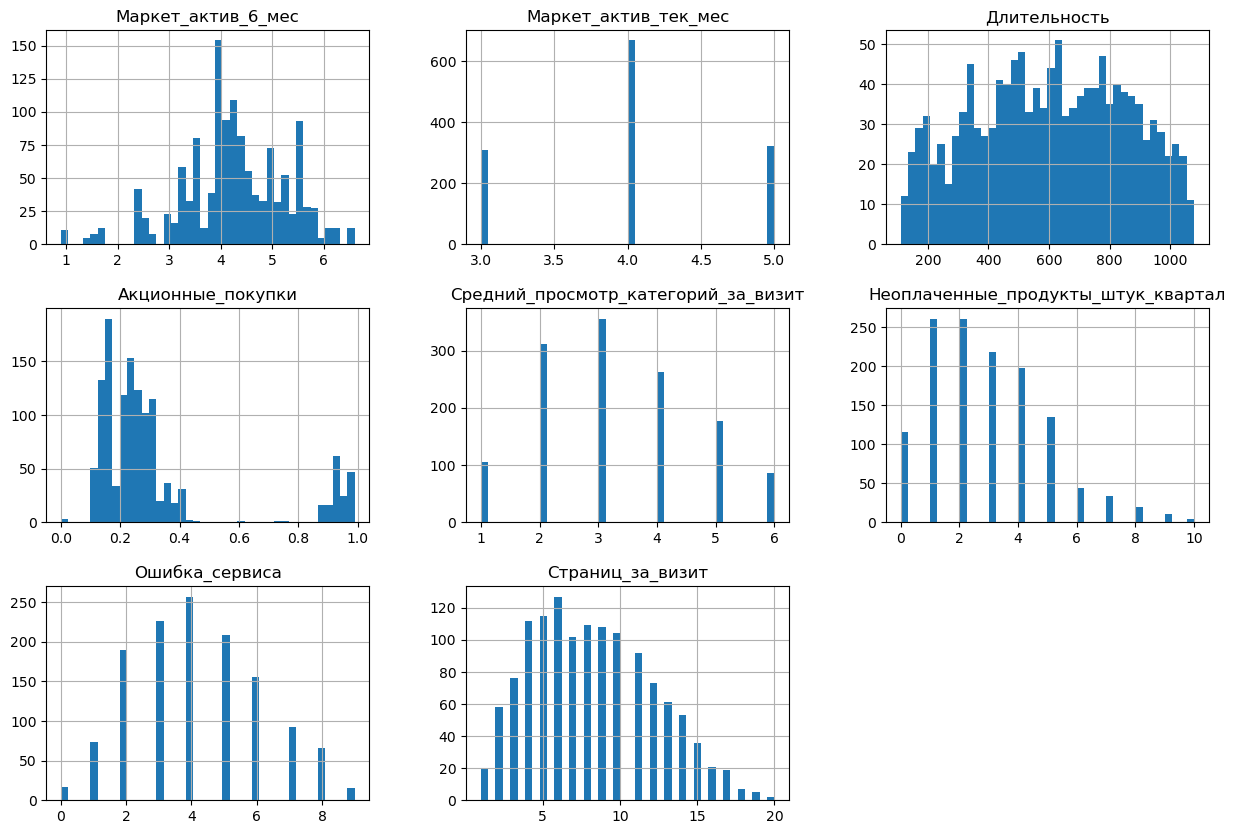

In [21]:
# строю гистограмму для всех числовых столбцов таблицы на одном графике
market.drop('id', axis=1).hist(figsize=(15, 10), bins=40);

In [22]:
market.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


По распределениям на нормальное похоже разве что распределение "Ошибки сервиса". У "Акционных покупок" две вершины - возможно проходили какие-то акции в период наблюдения.\
Описательная статистика тоже показывает, что у большинства признаков значительное стандартное отклонение.

In [23]:
col_boxplot = market.select_dtypes(include='number').columns.tolist()
len(col_boxplot)

9

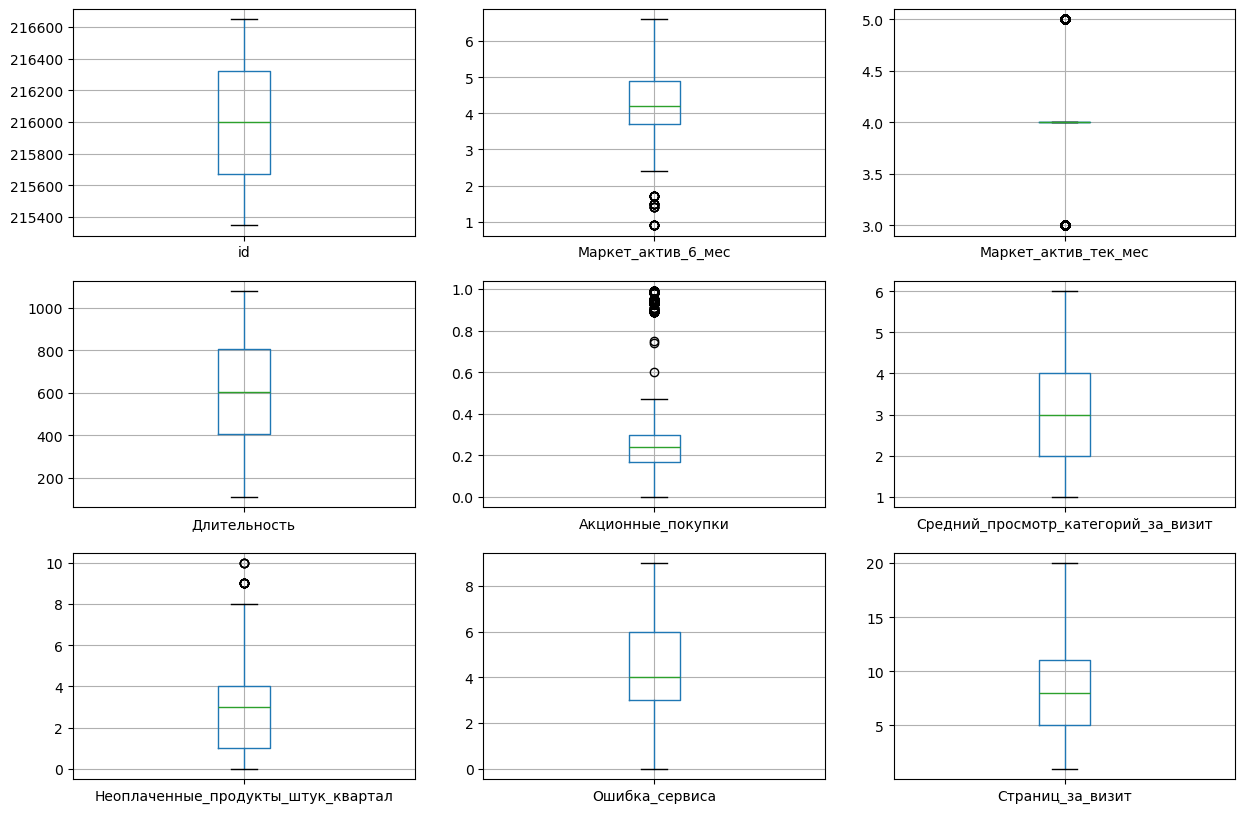

In [24]:
n=0
plt.figure(figsize=(15,10))
for col in col_boxplot:
    m=n+1
    plt.subplot(3, 3, m)
    n=m
    market.boxplot(col)

In [25]:
market.query('Маркет_актив_6_мес < 2')['id'].count()

36

In [26]:
market.query('Маркет_актив_тек_мес != 4')['id'].count()

631

In [27]:
market.query('Акционные_покупки > 0.5')['id'].count()

168

In [28]:
market.query('Неоплаченные_продукты_штук_квартал > 8')['id'].count()

14

Видны выбросы в колонках Маркет_актив_6_мес, Маркет_актив_тек_мес, Акционные_покупки и Неоплаченные продукты штук квартал.
Они не выглядят аномальными, поэтому думаю, что удалять или заменять их какими-то другими значениями не стоит.

### Исследовательский анализ данных второй таблицы *market_money*

In [29]:
market_money.head()

,id,Период,Выручка
0,215348,предпредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,предпредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


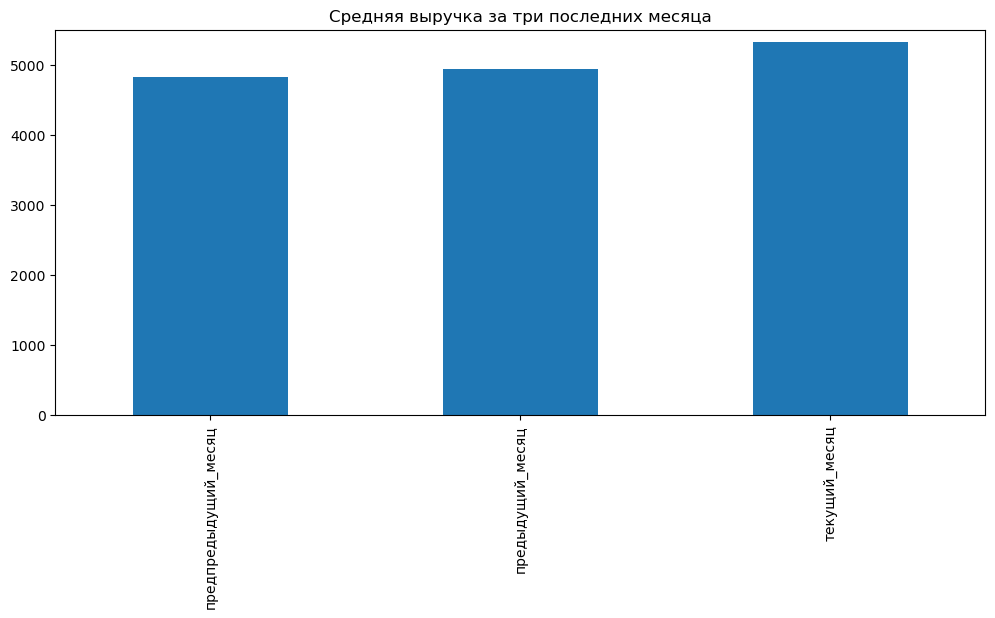

In [30]:
(market_money
 .pivot_table(index='Период', values='Выручка', aggfunc='mean')
 .plot(title='Средняя выручка за три последних месяца',
       kind='bar',
       ylim=(0, 5500),
       legend=False,
       figsize=(12, 5),
       xlabel='')
);

Средняя выручка от одного клиента составляет около 5 тысяч рублей в месяц. Заметно, что в наблюдаемые три месяца она по немногу росла.

In [31]:
market_money.groupby('Период')['Выручка'].sum()

Период
предпредыдущий_месяц    6272769.0
предыдущий_месяц        6417996.5
текущий_месяц           6909449.1
Name: Выручка, dtype: float64

Общий объем выручки в текущем месяце тоже выше, чем в предыдущих.

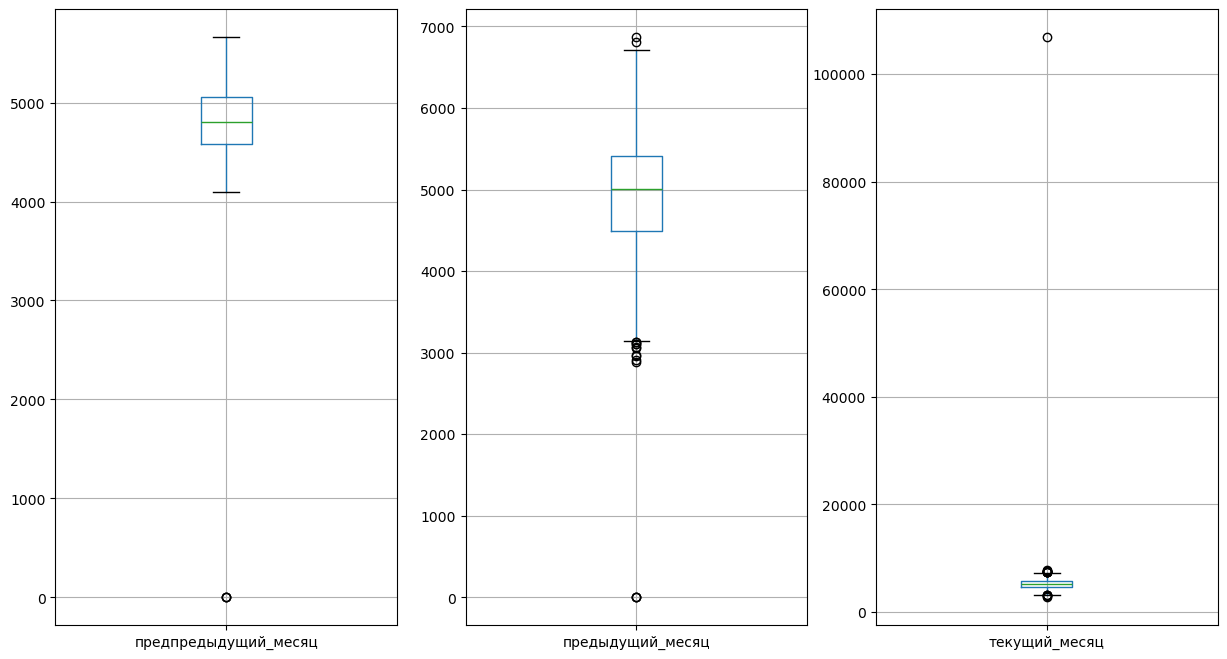

In [32]:
market_money_pivot2 = market_money.pivot_table(index='id', columns='Период', values='Выручка')
plt.figure(figsize=(15,8))
plt.subplot(1, 3, 1)
market_money_pivot2.boxplot('предпредыдущий_месяц');
plt.subplot(1, 3, 2)
market_money_pivot2.boxplot('предыдущий_месяц');
plt.subplot(1, 3, 3)
market_money_pivot2.boxplot('текущий_месяц');

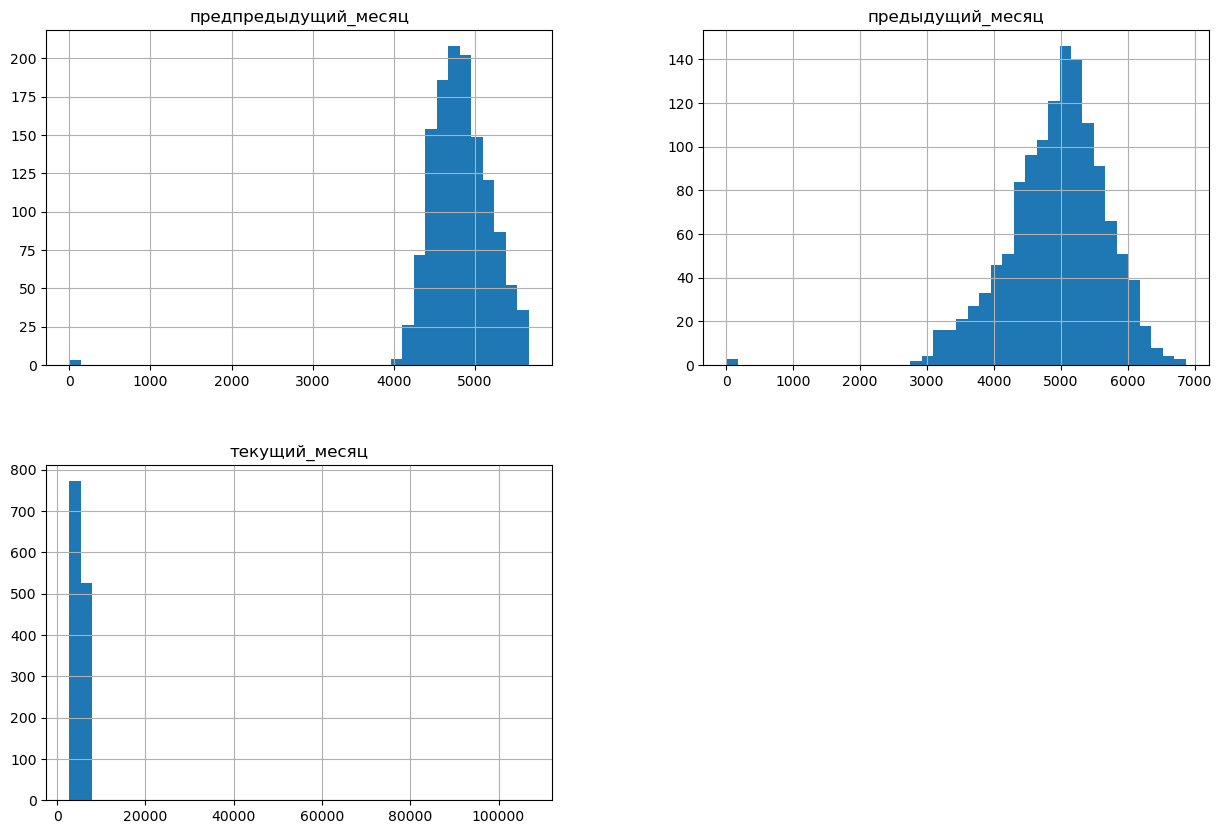

In [33]:
market_money_pivot2.hist(figsize=(15, 10), bins=40);

Очень бросается в глаза выброс, который искажает и диаграмму рассеивания и гистограмму. От него явно стоит избавиться.

In [34]:
market_money_pivot2.query('текущий_месяц > 20000')

Период,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
id,,,
215380,5051.0,6077.0,106862.2


In [35]:
market_money = market_money.query('id != 215380')

### Исследовательский анализ данных третьей таблицы *market_time*

In [36]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [37]:
market_time.groupby('Период')['минут'].mean()

Период
предыдущий_месяц    13.467692
текущий_месяц       13.204615
Name: минут, dtype: float64

Среднее время на сайте в текущем месяце составляет 13,2 минуты. Оно совсем немного, но снизилось по сравнению с предыдущим месяцем.

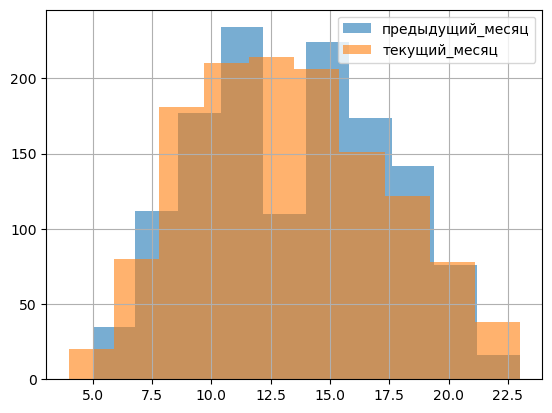

In [38]:
market_time.groupby('Период')['минут'].hist(legend=True, alpha=0.6);

В текущем месяце распределение проводимого на сайте времени выглядит нормальным. Больше всего клиентов проводили на сайте около 12,5 минут.\
А вот в прошлом месяце видно два пика. Возможно были какие-то рекламные компании, повлиявшие на время.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

### Исследовательский анализ данных четвертой таблицы *money*

In [39]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [40]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

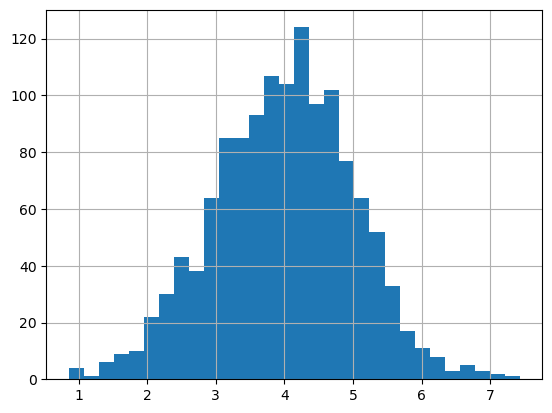

In [41]:
money['Прибыль'].hist(bins=30);

Показатель прибыли варьируется от примерно 1 до 7,4 процента. Средняя прибыль и мода близки и составляют почти 4%.
Распеределение немного смещено вправо, но близко к нормальному.

### Отобор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
Для этого возьму данные из таблицы *market_money*. Задание немного не ясно, но предположим, что нужны покупатели, которые совершали покупки в каждый из трех месяцев.

In [42]:
market_money_pivot = market_money.pivot_table(index='id', columns='Период', values='Выручка').reset_index()
market_money_pivot.head()

Период,id,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,4472.0,5216.0,4971.6
2,215350,4826.0,5457.5,5058.4
3,215351,4793.0,6158.0,6610.4
4,215352,4594.0,5807.5,5872.5


In [43]:
market_money_pivot_requested = market_money_pivot.loc[
    (market_money_pivot['предпредыдущий_месяц']>0) & (market_money_pivot['предыдущий_месяц']>0)
    & (market_money_pivot['текущий_месяц']>0)]

market_money_pivot_requested['id'].count()

1296

In [44]:
market_money_pivot.loc[
    (market_money_pivot['предпредыдущий_месяц']==0) | (market_money_pivot['предыдущий_месяц']==0)
    | (market_money_pivot['текущий_месяц']==0)]

Период,id,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
0,215348,0.0,0.0,3293.1
9,215357,0.0,0.0,5986.3
11,215359,0.0,0.0,4735.0


Получилось, что всего трое клиентов не подпадают под требование о трехмесячной активности. Сохраняю остальных в отдельный список.

In [45]:
id_requested = market_money_pivot_requested['id']

## Объединение таблиц
4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся.\
4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.


Сначала преобразую таблички, где в одном столбце данные по разным периодам, а затем уже объединю их в один датафрейм.

In [46]:
market = market.set_index('id')

In [47]:
market_money_pivot_requested = market_money_pivot_requested.set_index('id')
market_money_pivot_requested.columns = ['выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

In [48]:
market_money_pivot_requested.head()

,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
id,,,
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5
215353,5124.0,4738.5,5388.5


In [49]:
market_time_pivot = market_time.pivot_table(index='id', columns='Период', values='минут').reset_index().set_index('id')
market_time_pivot.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']

In [50]:
market_full = market.merge(market_money_pivot_requested, on = 'id')

In [51]:
market_full = market_full.merge(market_time_pivot, on = 'id')

In [52]:
market_full.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12.0,10.0
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8.0,13.0
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11.0,13.0
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8.0,11.0
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10.0,10.0


In [53]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит            

Все соединилось корректно, сохранились данные всех 1297 клиентов.

## Корреляционный анализ
Корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.


Для анализа корреляции между признаками построю матрицу корреляции и тепловую карту

In [54]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит            

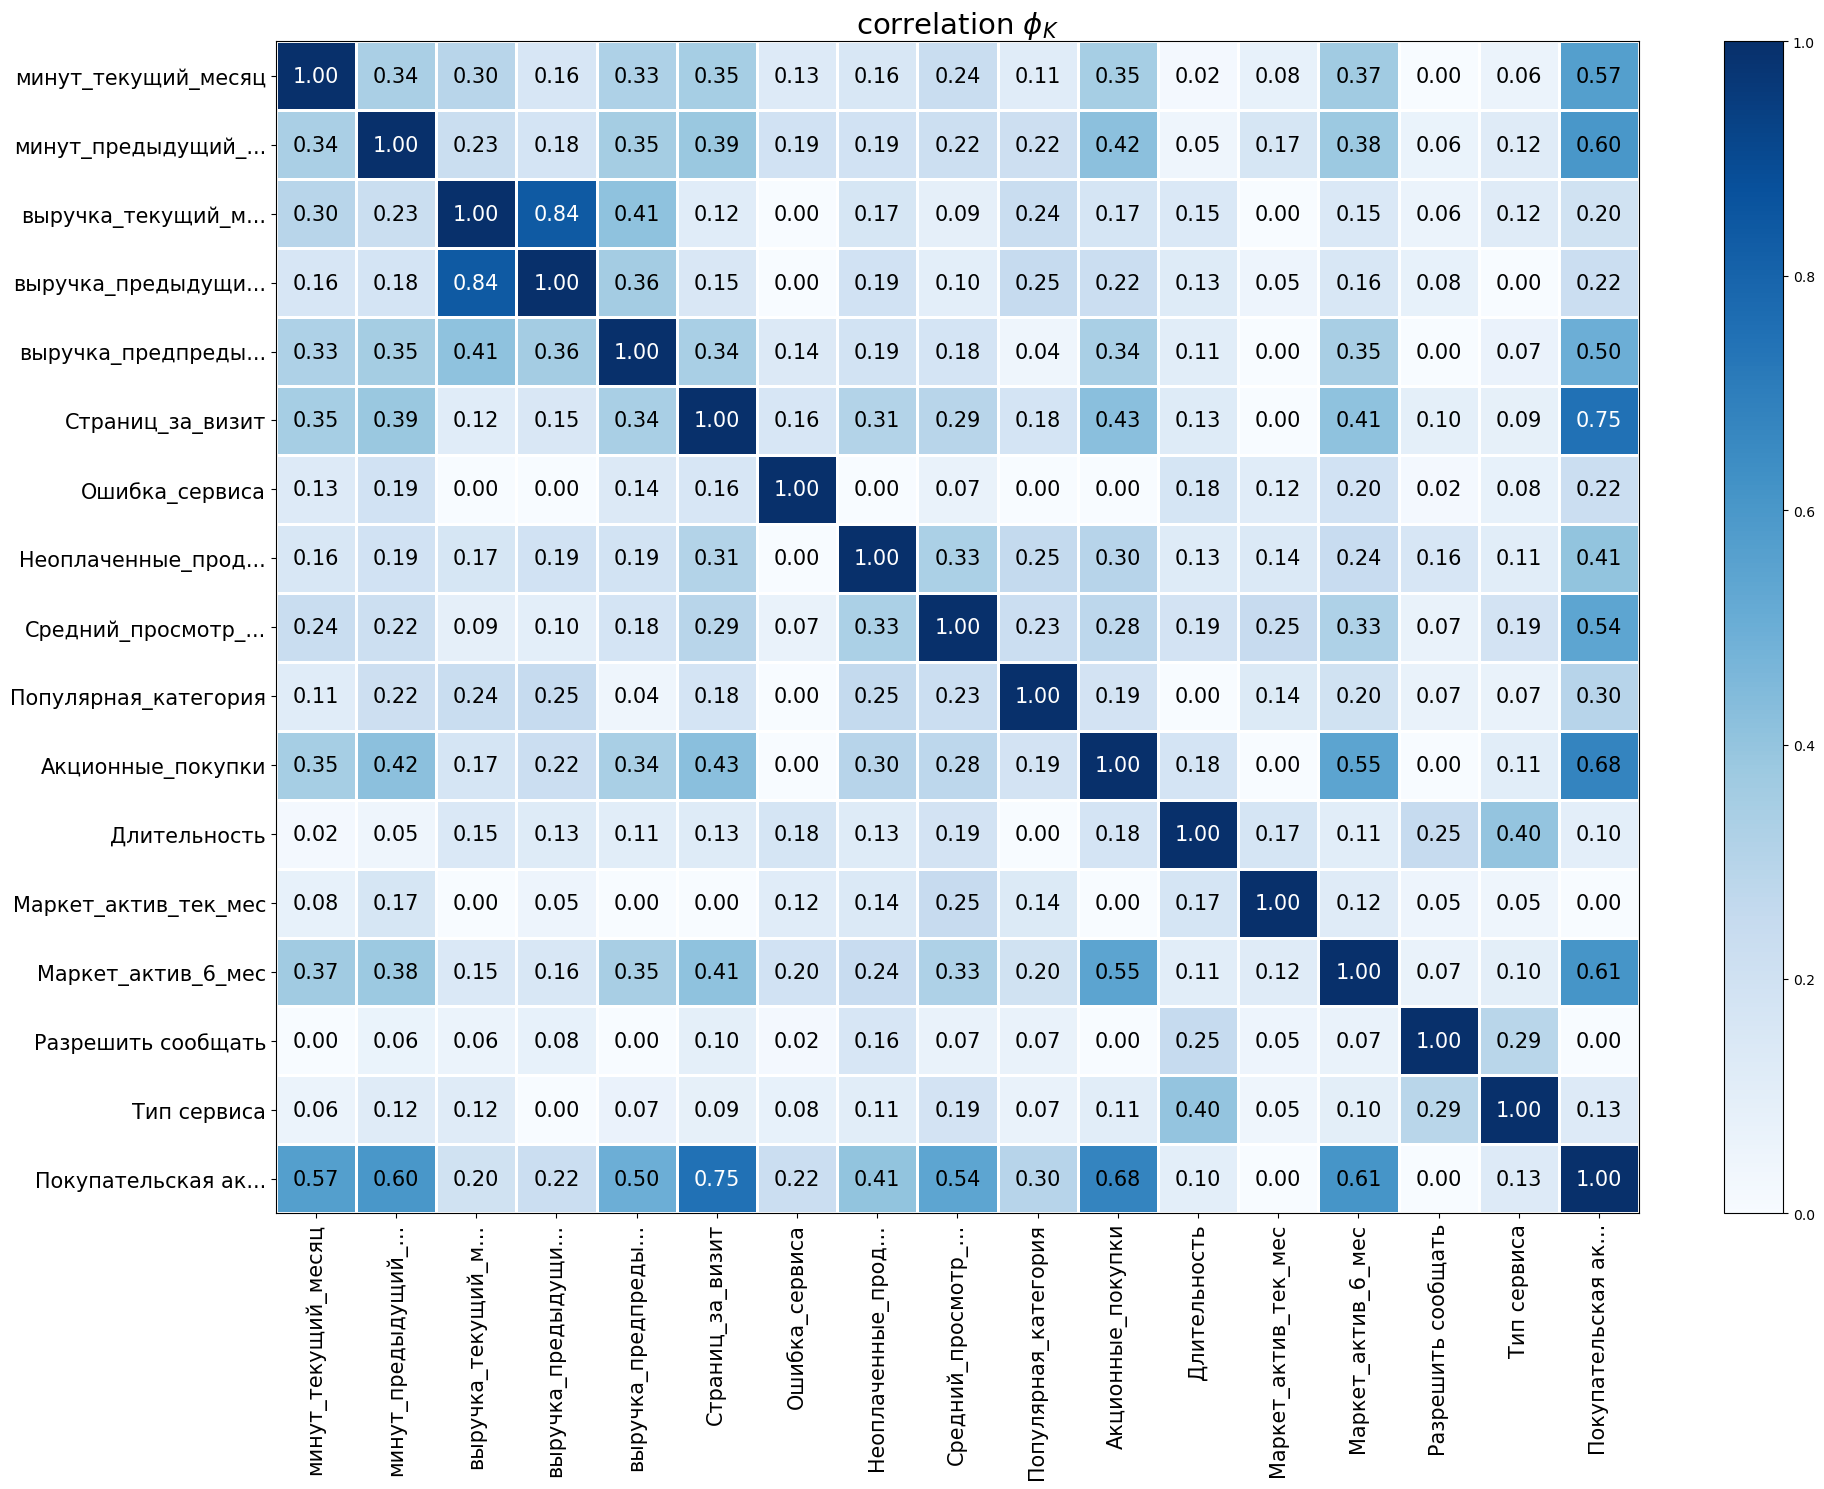

In [55]:
phik_overview = market_full.phik_matrix(
    interval_cols=['Длительность', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц', 'Прибыль'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

<font color='purple'><b>Строю графики scatter_plot для всех признаков (каждый по каждому)</b></font>

In [56]:
features = [
 'Тип сервиса',
 'Разрешить сообщать',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Популярная_категория',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'выручка_предпредыдущий_месяц',
 'выручка_предыдущий_месяц',
 'выручка_текущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц']

In [57]:
n=0
plt.figure(figsize=(15, 900))
for i in features:
    for j in features:
        m=n+1
        plt.subplot(300, 1, m)
        n=m
        sns.scatterplot(data=market_full, x=i, y=j, hue='Покупательская активность', palette="deep")

Error in callback <function _draw_all_if_interactive at 0x0000022037F58A40> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1500x90000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1500x90000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x90000 with 256 Axes>

Сильнее  всего "Покупательская активность" коррелирует с фактором "Страниц за визит" (среднее количество страниц, посещаемых при визите на сайт, за период 3 месяца) и <font color='purple'><b>Акионными покупками</b></font>. Также видна связь с минутами, проведенными на сайте, и активностью маркетологов за последние 6 месяцев и средним просмотром категорий за визит.\
<font color='purple'><b>Стали заметны связь между выручками в текущем и предыдущем месяце, а также активностью маркетологов за 6 месяцев и акционными покупками. Возможно, стоит удалить столбец с выручкой за текущий месяц и столбец с активностью маркетологов из-за мультиколлинеарности. Кроме того, выручка за текущий месяц может быть расчитана не совсем корректно, если месяц еще не закончился.</b></font>

## Использование пайплайнов

6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.\
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.\
6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.\
6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:\
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;\
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

**Буду использовать один общий пайплайн для выполнения задания**



In [58]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит            

In [59]:
TEST_SIZE=0.25
RANDOM_STATE=24

#разбиваю данные на тренировочную и тостовую выборки, указываяя целевой признак для стратификации
X_train, X_test, y_train, y_test = train_test_split(
    market_full.drop(['Покупательская активность'], axis=1),
    market_full['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_full['Покупательская активность'])

In [60]:
#выбираю колонки с категориальными признаками и напоминаю себе какие варианты значений они содержат 
cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
for i in cat_col_names:
    print(i, X_train[i].unique().tolist())
    print()

Тип сервиса ['стандарт', 'премиум']

Разрешить сообщать ['да', 'нет']

Популярная_категория ['Товары для детей', 'Техника для красоты и здоровья', 'Косметика и аксесуары', 'Кухонная посуда', 'Домашний текстиль', 'Мелкая бытовая техника и электроника']



Для признаков "Тип сервиса" и "Разрешить сообщать" определю кодирование OHE, а вот для "Популярной категории" выберу OrdinalEncoder чтобы не множить признаки.

In [61]:
ohe_columns = ['Тип сервиса', 'Разрешить сообщать']
ord_columns = ['Популярная_категория']

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Отлично, что разделяешь категории на порядковые и номинальные.</font>

In [62]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
num_columns

['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'выручка_предпредыдущий_месяц',
 'выручка_предыдущий_месяц',
 'выручка_текущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц']

In [63]:
# Пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
 )

В пайплайне выше я заменила значение handle_unknown с ignor на error, т.к. на шаге GridSearchCV что-то шло не так... Если честно, то не поняла причину.

In [64]:
# Ппайплайн для подготовки признаков ord_columns:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [65]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)    
    ], 
    remainder =  'passthrough'
)

In [66]:
# итоговый пайплайн для подготовки данных
final_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsClassifier())
    ]
)

In [67]:
#создаю словарь гиперпараметров
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 4),
        'models__max_features': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__kernel': ['linear', 'sigmoid', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

In [68]:
grid = GridSearchCV(
    final_pipeline, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    error_score='raise',
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         ['Тип '
                                                                          'сервиса',
                                                                          'Разрешить '
                                                                          'сообщать']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=24,
                                                        solver='liblinear')],
                          'models__C': range(1, 4),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=24)],
                          'models__kernel': ['linear', 'sigmoid', 'rbf'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [69]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')...
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'выручка_предпредыдущий_месяц',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'минут_предыдущий_месяц',
                                                   'минут_текущий_месяц'])])),
                ('models', SVC(probability=True, random_state=24))])

In [70]:
grid.best_params_, grid.best_score_

({'models': SVC(probability=True, random_state=24),
  'models__kernel': 'rbf',
  'preprocessor__num': StandardScaler()},
 0.9087329412056684)

Победил метод опорных векторов и StandardScaler.

In [71]:
proba = grid.predict_proba(X_test)[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, proba))

Площадь ROC-кривой: 0.9374671358653885


## Анализ важности признаков
7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.\
7.2 Сделайте выводы о значимости признаков:
какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.


Для начала провожу предобработку данных, согласно выданным пайплайном лучшим параметрам. 
Сначала пыталась воспользоваться пайплайном data_preprocessor, но не смогла сделать это корректно, поэтому решила вручную пройти шаги кодирований OHE, ORD и стандартизации посредтсвом StandardScaler.

In [73]:
ohe_encoder = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])

ohe_encoder_col_names = ohe_encoder.get_feature_names_out()

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)

print(X_train_ohe_df.head(5))


   Тип сервиса_стандарт  Разрешить сообщать_нет
0                   1.0                     0.0
1                   1.0                     0.0
2                   0.0                     0.0
3                   0.0                     0.0
4                   0.0                     0.0


In [ ]:
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

In [ ]:
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])

X_train_ord_df = pd.DataFrame(X_train_ord, columns=ord_columns)

print(X_train_ord_df.head(5))

In [ ]:
X_test_ord = ord_encoder.transform(X_test[ord_columns])
X_test_ord_df = pd.DataFrame(X_test_ord, columns=ord_columns)

In [ ]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train[num_columns])
X_train_scaled_df=pd.DataFrame(X_train_scaled, columns=num_columns)
X_train_scaled_df.head()

In [ ]:
X_test_scaled=scaler.transform(X_test[num_columns])
X_test_scaled_df=pd.DataFrame(X_test_scaled, columns=num_columns)
X_test_scaled_df.head()

Получив всю эту красоту осознала, в чем была моя ошибка. Для практики и чтобы не склеивать куски Х проделала то же самое всё-таки пайпланом data_preprocessor:

In [ ]:
fine_X_train = data_preprocessor.fit_transform(X_train)

In [ ]:
list(ohe_columns), list(ord_columns), list(num_columns)

In [ ]:
fine_X_train_df = pd.DataFrame(fine_X_train, columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория', 'Маркет_актив_6_мес',
  'Маркет_актив_тек_мес',
  'Длительность',
  'Акционные_покупки',
  'Средний_просмотр_категорий_за_визит',
  'Неоплаченные_продукты_штук_квартал',
  'Ошибка_сервиса',
  'Страниц_за_визит',
  'выручка_предпредыдущий_месяц',
  'выручка_предыдущий_месяц',
  'выручка_текущий_месяц',
  'минут_предыдущий_месяц',
  'минут_текущий_месяц'])

In [ ]:
fine_X_train_df.head()

In [ ]:
fine_X_test = data_preprocessor.transform(X_test)
fine_X_test_df = pd.DataFrame(fine_X_test, columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория', 'Маркет_актив_6_мес',
  'Маркет_актив_тек_мес',
  'Длительность',
  'Акционные_покупки',
  'Средний_просмотр_категорий_за_визит',
  'Неоплаченные_продукты_штук_квартал',
  'Ошибка_сервиса',
  'Страниц_за_визит',
  'выручка_предпредыдущий_месяц',
  'выручка_предыдущий_месяц',
  'выручка_текущий_месяц',
  'минут_предыдущий_месяц',
  'минут_текущий_месяц'])
fine_X_test_df.head()

Упорно пыталась проделать задание с победившей моделью, но ядро rbf не поддалось...
Обучаю модель с kernel='linear' вместо этого:

In [ ]:
model = SVC(random_state=RANDOM_STATE, kernel='linear', probability=True)
model.fit(fine_X_train, y_train)

Далее провожу анализ SHAP-значений, рисую диаграммы shap.plots.beeswarm и shap.plots.waterfall.

In [ ]:
explainer = shap.Explainer(model, fine_X_train)

In [ ]:
shap_values = explainer(fine_X_train_df)

In [ ]:
fine_X_train_df.shape

In [ ]:
shap.plots.beeswarm(shap_values, max_display=16) 

In [ ]:
shap.plots.bar(shap_values, max_display=16) 

Столбчатая диаграмма показывает общий вклад признаков в прогнозы модели. Признак "Страниц за визит" сильнее всего влияет на прогнозы модели. Далее идут минуты на сайте в предыдущем и текущем месяцах, на четвертом месте с небольшим отрывом "Акционные покупки".

##  Сегментация покупателей
8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.\
8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.\
8.3 Сделайте выводы о сегментах:
какой сегмент вы взяли для дополнительного исследования,
какие предложения вы сделали и почему.


По заданию в исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.\
~~Для этого дополню данные market_full. Сначала добавлю столбец с "Прибылью", а затем расчитаю "Доход", умножив прибыль на сумму выручки.~~

In [ ]:
market_full = market_full.merge(money, on = 'id')

<font color='purple'><b>Ниже меняю расчет дохода:</b></font>

In [ ]:
# убираю расчеты столбца доход и принимаю в качестве дохода выручку за три месяца
market_full['Доход'] = market_full['выручка_предпредыдущий_месяц']+market_full['выручка_предыдущий_месяц']+market_full['минут_текущий_месяц']

In [ ]:
market_full.head()

In [ ]:
market_full['Доход'].describe()

~~Клиент приносит в среднем примерно 60 000 за три месяца.~~
После перерасчета дохода с новым подходом получается, что в среднем клиент приносит примерно 9 800 рублей. Мода близка в средней, далее проверяю на наличие выбросов.

In [ ]:
market_full.boxplot('Доход');

Есть явные выбросы.

In [ ]:
market_full['Доход'].hist(bins=50);

In [ ]:
market_full.query('Доход < 100000')['Доход'].hist(bins=30);

<font color='purple'><b>Далее ориентируясь на полученный ящик с усами и гистограмму для работы беру только покупателей с суммарной выручкой в пределах 7500-11800 рублей.</b></font>

In [ ]:
market_full_norm=market_full.query('Доход < 11800')
market_full_norm=market_full_norm.query('Доход > 7500')
market_full_norm['Доход'].describe()

~~Даже если отбросить покупателей, которые принесли магазину сверхдоходы по сравнению с остальными клиентами, то средняя всё равно остается на уровне около 60 000 рублей, как и медиана.~~\
Можно еще взглянуть на гистограмму с группировкой по покупательской активности.

In [ ]:
market_full_norm.groupby('Покупательская активность')['Доход'].hist(bins=50, legend=True, alpha=0.6, density=True);

~~Разделю покупателей на несколько категорий, исходя из принесенного ими дохода.\
<font color='purple'><b>Меняю сегменты в связи с перерасчетом столбца "Доход".</b></font> ~~

<font color='purple'><b>Чувствовала, что что-то не так в моих мыслях... И вот! Нашла в инстукции примеры сегментирования покупателей, которые привязаны не только к доходу... Моя зацикленность на сегментации по доходу, наверное, была связана с тем, что я финансист...</b></font>

In [ ]:
#беру тестовую выборку и добавляю столбец с вероятностями снижения покупательской активности
proba = grid.predict_proba(X_test)[:, 1]
X_test['Вероятность']= proba

In [ ]:
#строю гистограмму, чтобы посмотреть на распределение
X_test['Вероятность'].hist();

Очень хорошо заметно, что есть группы с большей и меньшей вероятностью снижения покупательской активности. Для анализа выберу группу покупателей, у которой вероятность снижения покуптельской активности свыше 0,9.

In [ ]:
my_target_segment = X_test[X_test['Вероятность']>0.9]

In [ ]:
my_target_segment.shape

In [ ]:
my_target_segment['Популярная_категория'].value_counts().sort_values().plot.barh()
plt.title('Популярная категория', size="xx-large")
plt.xlabel("Количество покупателей");

Количество клиентов с высокой вероятностью снижения покупательской активности составила 82 человека. Их любимая категория - это товары для детей. На втором месте "косметика и аксесуары" и "домашний текстиль".

Для данного сегмента покупателей можно попробовать повысить количество страниц просматриваемых на сайте и увеличить количество минут, то есть нужно заинтересовать их интересными предложениями об их самых популярных категориях - Товары для детей, Косметика и аксесуары или Домашний текстиль, внимание к которым бы побуждало их больше времени проводить на сайте.

## Общий вывод

В целях удержания и увеличения покупательской активности клиентов своего интернет-магазин «В один клик» Заказчик решил персонализировать предложения постоянным клиентам.\
Для этого было проеведена разработка решения для персонализации, включающая следующее:\
1. Построена модель, предсказывающая вероятность снижения покупательской активности клиента в следующие три месяца.
2. Было проведено исследование дополнительных данных финансового департамента о прибыльности клиента: расчитан доход принесенный каждым покупателем компании за последние три месяца, а также суммарные выручка и доход.
3. С использованием данныых модели и данных о прибыльности клиентов выделены четыре сегмента покупателей и рекомендованы варианты разработки предложений для одного из них.

Для построения модели бьла проведена предобработка и исследовательский анализ данных, полученных от Заказчика. Затем данные были объединены в один общий дата фрейм.\
Был проведен корреляционный анализ всех признаков, который показал связь между целевым признаком "Покупательская активность" с фактором "Страниц за визит" (среднее количество страниц, посещаемых при визите на сайт, за период 3 месяца), а также с минутами, проведенными на сайте, активностью маркетологов за последние 6 месяцев и средним просмотром категорий за визит.\
Для выбора лучшего варианта предподготовки данных, подбора модели и ее лучших гиперпараметров использовался пайплайн, подобравший в качестве лучших SVC("kernel': 'rbf') и StandardScaler().\
Был проведен анализ важности признаков модели, который показал, что признак "Страниц за визит" сильнее всего влияет на прогнозы модели, далее идут минуты на сайте в предыдущем и текущем месяцах, а затем "Акционные покупки".\
Заказчику даны рекомендации для одного из мегментов покупателей: повысить количество страниц просматриваемых на сайте и увеличить количество минут, то есть нужно заинтересовать их интересными предложениями об их самых популярных категориях - товары для детей или домашний текстиль, внимание к которым бы побуждало их больше времени проводить на сайте.